<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Regularization

_Authors: Kiefer Katovich (SF)_

---

### Learning Objectives 
- Articulate what is regularization for regression models
- Define how regularization modifies the loss function
- Define the effect of regularization on coefficients
- Define the differences between the Lasso, Ridge, and ElasticNet
- Implement and visualize the penalties using sklearn

### Lesson Guide
- [Overview of regularization](#intro)
- [Review: the least-squares loss function](#lsq-loss)
- [The Ridge penalty](#ridge)
- [The Lasso penalty](#lasso)
- [The Elastic-Net penalty](#elastic-net)
- [What is the effect of regularization](#effect)
- [Standardizing predictors is required](#standardization)
- [Visualizing the Ridge](#viz-ridge)
- [Visualizing the Lasso](#viz-lasso)
- [Visualizing the Elastic-Net](#viz-elastic-net)
- [Model performance with complex predictor matrix using regularization](#model-performance)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<a id='intro'></a>

## Overview of regularization

---

The goal of "regularizing" regression models is to structurally prevent overfitting by imposing a penalty on the coefficients of the model.

Regularization methods like the Ridge and Lasso add this additional "penalty" on the size of coefficients to the loss function. When the loss function is minimized, this additional component is added to the residual sum of squares.

In other words, the minimization becomes a balance between the error between predictions and true values and the size of the coefficients. 

The two most common types of regularization are the **Lasso**, **Ridge**. There is a mixture of them called the **Elastic Net**. We will take a look at the mathematics of regularization and the effect these penalties have on model fits.


<a id='lsq-loss'></a>

## Review: least squares loss function

---

Ordinary least squares regression minimizes the residual sum of squares (RSS) to fit the data:

### $$ \text{minimize:}\; RSS = \sum_{i=1}^n (y_i - \hat{y}_i)^2 = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 $$

Where our model predictions for $y$ are based on the sum of the $beta_0$ intercept and the products of $\beta_i$ with $x_i$.

Alternatively, in matrix notation using predictor matrix $X$, residual errors $\epsilon$ and vector of beta coefficients $\beta$:

### $$ \text{minimize:}\; RSS = \epsilon' \epsilon = (y - \beta X)' (y - \beta X) $$

<a id='ridge'></a>

## The Ridge penalty

---

Ridge regression adds the sum of the squared (non-intercept!) $\beta$ values to the loss function:

### $$ \text{minimize:}\; RSS+Ridge = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_2\sum_{j=1}^p \beta_j^2$$

**Where:**

$\beta_j^2$ is the squared coefficient for variable $x_j$.

$\sum_{j=1}^n \beta_ij^2$ is the sum of these squared coefficients for every variable we have in our model. This does **not** include the intercept $\beta_0$.

$\lambda_2$ is a constant for the _strength_ of the regularization parameter. The higher this value, the greater the impact of this new component in the loss function. If this were zero, then we would revert back to just the least squares loss function. If this were, say, a billion, then the residual sum of squares component would have a much smaller effect on the loss/cost than the regularization term.

With the penalty added the RSS is referred to as the **penalized residual sum of squares (PRSS)**. In matrix format the Ridge PRSS is:

### $$ \text{Ridge PRSS} = (y - \beta X)' (y - \beta X) + \lambda_2 \; ||\beta||^2 $$

Where $||\beta||_2^2$ is the squared norm of the coefficient vector (again, excluding intercept).

The derivative we set to zero to solve for the coefficients becomes:

### $$ \frac{\partial PRSS}{\partial \beta} = -2X'y + 2X'X\beta + 2\lambda_2 \beta$$

and the solution to the beta coefficient vector is:

### $$ \text{Ridge }  \beta = (X'X + \lambda_2I)^{-1}X'y $$

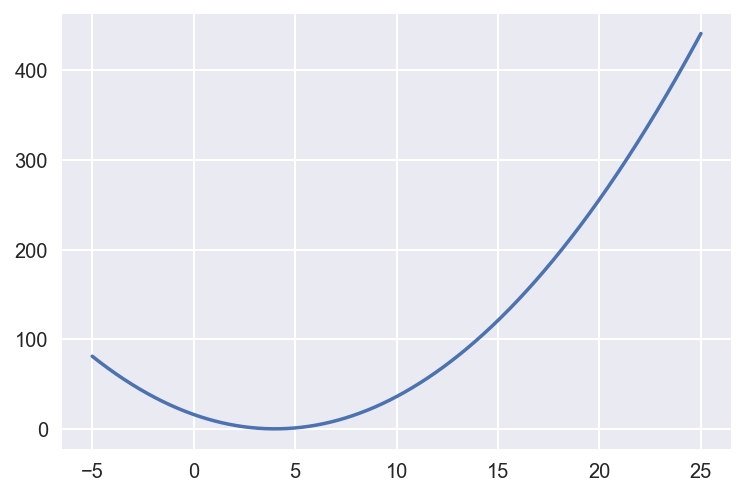

In [2]:
y_test = 5

beta = np.linspace(-1 * y_test, 5 * y_test, 1000)
alpha = 1
f = lambda beta: (y_test - (1 + beta * 1))**2# + alpha * beta**2
# quadratic shape for loss function because x is squared

y = f(beta)

_ = plt.plot(beta,y)

- Take a look at the minimum for different values of y_test: try small values like 4, 5, 6 etc. Take 2 minutes
- Then try a few 'outliers' for example: 50, 100, -100; you may need to change the range of the x array. Take 2 minutes.
- Be prepared to talk about how regularization affects the weight that is learned.
- Be prepared to talk about how alpha affects the regularization

<a id='lasso'></a>

## The Lasso penalty

---

The Lasso regression takes a different approach. Instead of adding the sum of _squared_ $\beta$ coefficients to the RSS, it adds the sum of the _absolute values_ of the $\beta$ coefficients:

### $$ \text{minimize:}\; RSS + Lasso = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_1\sum_{j=1}^p |\beta_j|$$

**Where:**

$|\beta_j|$ is the absolute value of the $\beta$ coefficient for variable $x_j$

$\lambda_1$ is again the strength of the regularization penalty component in the loss function. In lasso the lambda is denoted with a 1, in ridge the lambda is denoted with a 2.


**In matrix format the Lasso PRSS is:**

### $$ \text{Lasso PRSS} = (y - \beta X)' (y - \beta X) + \lambda_1 \; ||\beta|| $$

Unlike the Ridge, however, there is not a closed-form solution for the Lasso beta coefficients.

<a id='elastic-net'></a>

## Elastic Net penalty

---

Elastic Net is simply a combination of the Lasso and the Ridge regularizations. It adds *both* penalties to the loss function:

### $$ \text{minimize:}\; RSS + Ridge + Lasso = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_1\sum_{j=1}^p |\beta_j| + \lambda_2\sum_{j=1}^p \beta_j^2$$

In the elastic net, the effect of the Ridge vs. the Lasso is balanced by the two lambda parameters. 

<a id='effect'></a>

## What is the effect of regularization?

---

**To demonstrate the effects we will be using a dataset on wine quality.**

An important aspect of this data, which is a reason why we might choose to use regularization, is that there is **multicollinearity** in the data. The term multicollinearity means that there are high correlations between predictor variables in your model. 

**This can lead to a variety of problems including:**
1. The effect of predictor variables estimated by your regression will depend on what other variabes are included in your model.
2. Predictors can have wildly different effects depending on the observations in your sample, and small changes in samples can result in very different estimated effects.
3. With very high multicollinearity, the inverse matrix the computer calculates may not be accurate.
4. We can no longer interpret a coefficient on a variable as the effect on the target of a one unit increase in that variable holding the other variables constant. This is because when predictors are strongly correlated, there is not a scenario in which one variable can change without a conditional change in another variable.

The Ridge is best suited to deal with multicollinearity. Lasso also deals with multicollinearity between variables, but in a more brutal way (it "zeroes out" the less effective variable).

The Lasso is particularly useful when you have redundant or unimportant variables. If you have 1000 variables in a dataset the Lasso can perform "feature selection" automatically for you by forcing coefficients to be zero.

### Load the wine csv

This version has red and white wines concatenated together and tagged with a binary 1,0 indicator (1 is red wine). There are many other variables purportedly related to the rated quality of the wine.

In [17]:
# wine = pd.read_csv('../../../unit-3/regression-ridge-lasso/datasets/winequality_merged.csv')
wine = pd.read_csv('./basketball_reference/game_logs/James_LeBron_2017.csv')

# replace spaces in column names and convert all columns to lowercase:
wine.columns = [x.lower().replace(' ','_') for x in wine.columns]

In [19]:
wine.head(2)

,game,date,team,loc,opp,result,gs,mp,fg,fga,...,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,off_rtg,def_rtg,name
0,1,2016-10-25,CLE,NaN,NYK,W (+29),1,32:23,9,14,...,22.4,17.5,65.5,0.0,2.5,21.2,24.1,129,90,LeBron James
1,2,2016-10-28,CLE,@,TOR,W (+3),1,38:40,7,16,...,15.2,10.9,35.7,0.0,0.0,20.8,28.3,103,100,LeBron James


In [20]:
wine.columns

Index([u'game', u'date', u'team', u'loc', u'opp', u'result', u'gs', u'mp',
       u'fg', u'fga', u'fg_pct', u'fg3', u'fg3a', u'fg3_pct', u'ft', u'fta',
       u'ft_pct', u'orb', u'drb', u'trb', u'ast', u'stl', u'blk', u'tov',
       u'pf', u'pts', u'gmsc', u'plus_minus', u'ts_pct', u'efg_pct',
       u'orb_pct', u'drb_pct', u'trb_pct', u'ast_pct', u'stl_pct', u'blk_pct',
       u'tov_pct', u'usg_pct', u'off_rtg', u'def_rtg', u'name'],
      dtype='object')

In [21]:
# data cleaning for all game_log files
wine['date'] = pd.to_datetime(wine['date'])
wine.rename(columns={'loc': 'Home_Game'}, inplace=True)
wine['Home_Game'] = [0 if item == "@" else 1 for item in wine['Home_Game']]
wine['result'] = [item[3:].replace(")","") for item in wine['result']]
wine['result'] = wine['result'].astype(float)
wine['mp'] = [0 if pd.isnull(item) else round(float(item.split(":")[0]) + float(item.split(":")[1])/60. , 2) for item in wine['mp']]

In [25]:
wine.shape

(74, 41)

In [29]:
cols = list(wine.columns.values[5:-1])

In [31]:
cols = [col for col in cols if col not in ['fg_pct','fg3_pct','ft_pct']] + ['Home_Game']

In [32]:
cols

['result',
 'gs',
 'mp',
 'fg',
 'fga',
 'fg3',
 'fg3a',
 'ft',
 'fta',
 'orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',
 'gmsc',
 'plus_minus',
 'ts_pct',
 'efg_pct',
 'orb_pct',
 'drb_pct',
 'trb_pct',
 'ast_pct',
 'stl_pct',
 'blk_pct',
 'tov_pct',
 'usg_pct',
 'off_rtg',
 'def_rtg',
 'Home_Game']

In [34]:
wine.shape

(73, 41)

In [35]:
wine = wine.dropna(axis=0, how='any')

In [36]:
wine.shape

(73, 41)

**Look at the correlation between variables.**

In [37]:
wine_corr = wine.corr()
wine_corr[['result']].T

,game,Home_Game,result,gs,mp,fg,fga,fg_pct,fg3,fg3a,...,orb_pct,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,off_rtg,def_rtg
result,-0.175462,0.316129,1.0,NaN,-0.220616,0.076162,-0.163199,0.330495,-0.028539,-0.162339,...,-0.193578,-0.046939,-0.014949,0.223871,0.043542,0.226994,-0.091967,-0.171617,0.569037,-0.495741


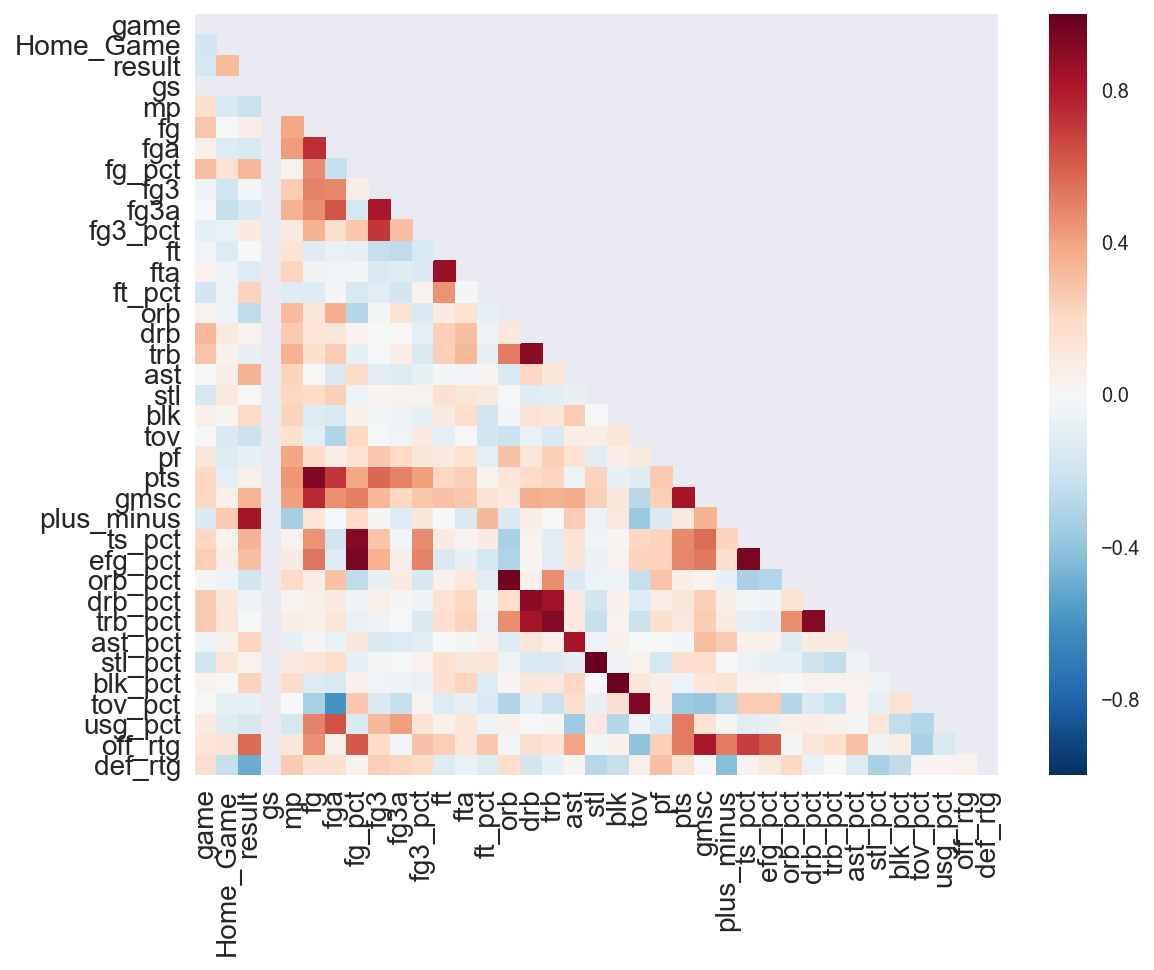

In [38]:
# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(wine_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(wine_corr, mask=mask, ax=ax)#, annot=True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

<a id='standardization'></a>

## Standardizing predictors is required

---

With the Lasso and Ridge it is neccessary to standardize the predictor columns before constructing the models, even the dummy coded categorical variables. 

Below we define our target variable and then normalize the columns that are not the target.

Recall the equations for the Ridge and Lasso penalties:

### $$ \text{Ridge penalty}\; = \lambda_2\sum_{j=1}^p \beta_j^2$$

### $$ \text{Lasso penalty}\; = \lambda_1\sum_{j=1}^p |\beta_j|$$

**How are the $\beta$ coefficients affected by the mean and variance of your variables?**

If the mean and variance of your $x$ predictors are different, their respective $\beta$ coefficients *scale with the mean and variance of the predictors regardless of their explanatory power.*

This means that if one of your $x$ variables, for example the fixed acidity, will have a much smaller $\beta$ value than say the citric acid – just because the scale of the two variables are so different!

The Ridge and Lasso penalties do not take into account to the mean and variance of your predictors, so the adjustment is up to you. All they "care about" are the values of the coefficients.

In [60]:
# select all the columns that are not the target
# nc = [x for x in wine.columns if x != target]

In [61]:
# Choose a target/dependent variable that we will predict
target = 'result'

In [62]:
X = wine[cols]
Y = wine[target]

In [63]:
# standard scalar
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
X = pd.DataFrame(X, columns=cols)

In [65]:
del X['result']
del X['gs']

In [66]:
X.head()

,mp,fg,fga,fg3,fg3a,ft,fta,orb,drb,trb,...,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,off_rtg,def_rtg,Home_Game
0,-1.170943,-0.351731,-0.987173,-1.124990,-0.693005,-1.719490,-1.886530,1.271523,0.241497,0.756619,...,0.212184,1.154410,2.017643,-1.255548,0.728071,0.723837,-1.483060,0.572942,-1.502431,0.933700
1,0.221747,-1.129803,-0.506749,0.210364,0.571729,0.042233,-0.098002,0.510694,-0.524994,-0.229688,...,-0.851976,-0.449844,-0.332277,-1.255548,-0.754886,0.665739,-0.445865,-1.097479,-0.694791,-1.071008
2,0.294813,-1.129803,-0.506749,0.210364,0.571729,0.923095,1.332821,-0.250136,-0.908240,-0.887225,...,-0.822416,-1.106129,0.038348,-0.274069,0.550116,-1.077200,-1.137329,0.123213,-0.452500,0.933700
3,-0.402639,-1.518839,-1.467598,-0.457313,-0.693005,0.482664,0.975115,1.271523,1.007989,1.414156,...,1.305905,2.321140,-0.734445,-1.255548,-0.754886,0.491445,-1.162024,0.187460,1.485836,0.933700
4,-0.287504,0.815377,0.934524,-0.457313,-0.271427,0.042233,-0.813413,-0.250136,-0.524994,-0.558457,...,-0.497256,-0.328309,1.812617,-0.274069,-0.754886,-1.251493,0.443159,1.022671,1.243544,0.933700


### Create the target and predictor matrix with patsy

We will be making two X, Y datasets. One of them will be dramatically more complex (and thus overfit).

1. The first is going to just be all the variables added together.
2. The second will have all interactions between the variables included. This should overfit the target quite a bit!


In [121]:
# import patsy

# # Get the non-target cols with a simple list comprehension
# non_target_cols = [c for c in wine.columns if c != target]

# # Use some string adding and joining to make the simple model formula:
# formula_simple = target + ' ~ ' + ' + '.join(non_target_cols) + ' -1'
# print(formula_simple)

# print 

# # Make the complex formula:
# formula_complex = target + ' ~ (' + ' + '.join(non_target_cols) + ')**2 -1'
# print (formula_complex)

# # Create the X and Y pairs for both!
# Y, X = patsy.dmatrices(formula_simple, data=wine, return_type='dataframe')
# Yoverfit, Xoverfit = patsy.dmatrices(formula_complex, data=wine, return_type='dataframe')

# Y = Y.values.ravel()
# Yoverfit = Yoverfit.values.ravel()


In [67]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=8)

/Users/anthony-mba/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**Look at how the shapes of the X matrices differ. You can see that the Xoverfit has considerably more columns due to the creation of all possible two-way interactions.**

In [68]:
print X_train.shape, y_train.shape, X_test.shape, y_test.shape

(51, 31) (51,) (22, 31) (22,)


<a id='viz-ridge'></a>

## Visualizing the Ridge

---

Import the `Ridge` model class from sklearn.

In [69]:
from sklearn.linear_model import Ridge

This function iterates over a series of different alpha regularization parameters. The alpha is sklearn's equivalent of the lambda value in the formula that multiples the square of betas from the equation.

The function stores the results of the model so that we can plot them interactively.

In [70]:
def ridge_coefs(X, Y, alphas):
    
    # set up the list to hold the different sets of coefficients:
    coefs = []
    
    # Set up a ridge regression object
    ridge_reg = Ridge()
    
    # Iterate through the alphas fed into the function:
    for a in alphas:
        
        # On each alpha reset the ridge model's alpha to the current one:
        ridge_reg.set_params(alpha=a)
        
        # fit or refit the model on the provided X, Y
        ridge_reg.fit(X, Y)
        
        # Get out the coefficient list
        coefs.append(ridge_reg.coef_)
        
    return coefs

Alpha values for the ridge are best visualized on a logarithmic "magnitude" scale. Essentially, the effect of alpha on the coefficients does not increase linearly but by orders of magnitude. 

In [71]:
# np.logspace gives us points between specified orders of magnitude on a logarithmic scale. It is base 10.
r_alphas = np.logspace(0, 5, 200)

# Get the coefficients for each alpha for the Ridge, using the function above
r_coefs = ridge_coefs(X, Y, r_alphas)

The plotting function below will:

 - Plot the effect of changing alpha on the coefficient size on a **path** graph
 - Plot the effect of changing alpha on the coefficient size on a **bar** graph
 
Each one gives informative information. It's just two different ways of visualizing the same thing. The chart is interactive so you can play around with the values of alpha across the specified range above.

In [72]:
# The cycler package lets us "cycle" throug colors.
# Just another thing i had to look up on stackoverflow. That's my life.
from cycler import cycler

def coef_plotter(alphas, coefs, feature_names, to_alpha, regtype='ridge'):
    
    # Get the full range of alphas before subsetting to keep the plots from 
    # resetting axes each time. (We use these values to set static axes later).
    amin = np.min(alphas)
    amax = np.max(alphas)
    
    # Subset the alphas and coefficients to just the ones below the set limit
    # from the interactive widget:
    alphas = [a for a in alphas if a <= to_alpha]
    coefs = coefs[0:len(alphas)]
    
    # Get some colors from seaborn:
    colors = sns.color_palette("husl", len(coefs[0]))
    
    # Get the figure and reset the size to be wider:
    fig = plt.figure()
    fig.set_size_inches(18,5)

    # We have two axes this time on our figure. 
    # The fig.add_subplot adds axes to our figure. The number inside stands for:
    #[figure_rows|figure_cols|position_of_current_axes]
    ax1 = fig.add_subplot(121)
    
    # Give it the color cycler:
    ax1.set_prop_cycle(cycler('color', colors))
    
    # Print a vertical line showing our current alpha threshold:
    ax1.axvline(to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot the lines of the alphas on x-axis and coefficients on y-axis
    ax1.plot(alphas, coefs, lw=2)
    
    # set labels for axes:
    ax1.set_xlabel('alpha', fontsize=20)
    ax1.set_ylabel('coefficients', fontsize=20)
    
    # If this is for the ridge, set this to a log scale on the x-axis:
    if regtype == 'ridge':
        ax1.set_xscale('log')
    
    # Enforce the axis limits:
    ax1.set_xlim([amin, amax])
    
    # Put a title on the axis
    ax1.set_title(regtype+' coef paths\n', fontsize=20)
    
    # Get the ymin and ymax for this axis to enforce it to be the same on the 
    # second chart:
    ymin, ymax = ax1.get_ylim()

    # Add our second axes for the barplot in position 2:
    ax2 = fig.add_subplot(122)
    
    # Position the bars according to their index from the feature names variable:
    ax2.bar(range(1, len(feature_names)+1), coefs[-1], align='center', color=colors)
    ax2.set_xticks(range(1, len(feature_names)+1))
    
    # Reset the ticks from numbers to acutally be the names:
    ax2.set_xticklabels(feature_names, rotation=90, fontsize=12)
    
    # enforce limits and add titles, labels
    ax2.set_ylim([ymin, ymax])
    ax2.set_title(regtype+' predictor coefs\n', fontsize=20)
    ax2.set_xlabel('coefficients', fontsize=20)
    ax2.set_ylabel('alpha', fontsize=20)
    
    plt.show()


Load the ipython widgets so we can make this plotting function interactive!

In [73]:
from ipywidgets import *
from IPython.display import display

The function and `interact` from ipywidgets lets me take some specified alphas that we have already calculated the coefficients for and plot them out.

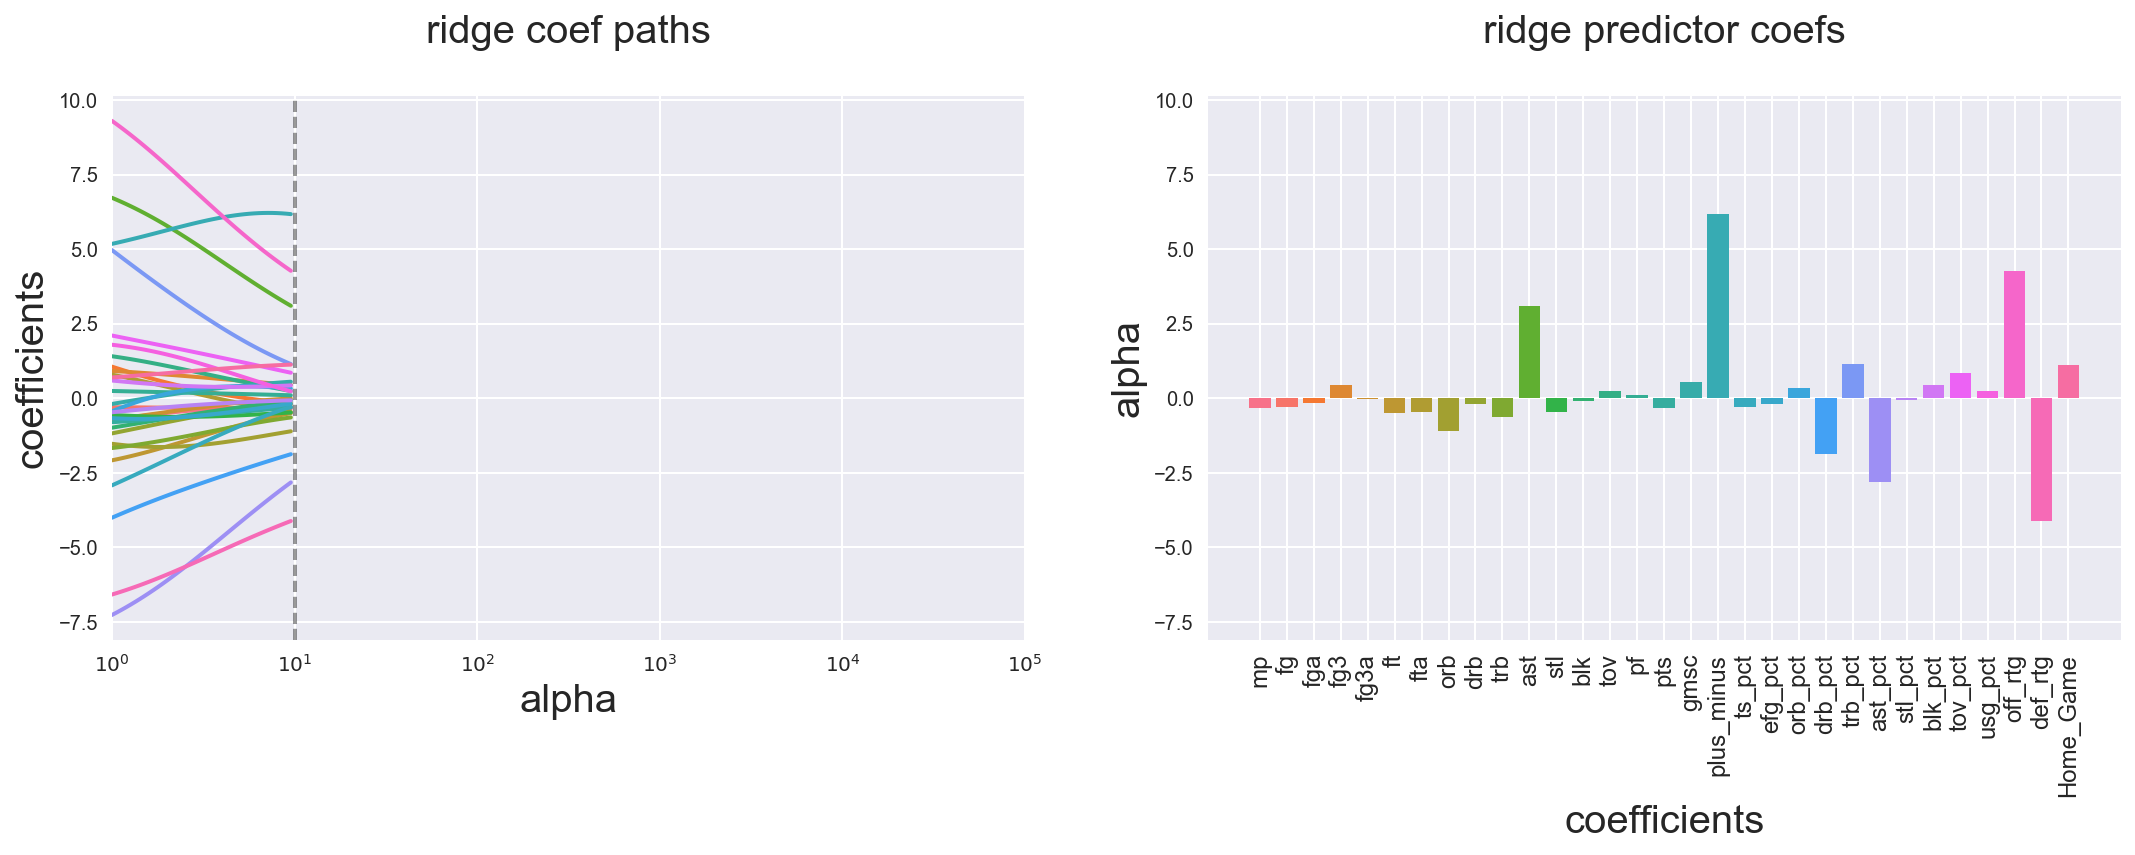

In [74]:
def ridge_plot_runner(log_of_alpha=0):
    coef_plotter(r_alphas, r_coefs, X.columns, 10**log_of_alpha, regtype='ridge')

interact(ridge_plot_runner, log_of_alpha=(0.0,5.0,0.05))

- What is happening here as you vary the alpha?
- How are large parameters affected vs small paramters?

<a id='viz-lasso'></a>

## Visualizing the Lasso

---

Now we do the same thing as above but for the Lasso. You will be able to see how the coefficients change differently for both.

In [75]:
from sklearn.linear_model import Lasso

In [76]:
# This is the same as the ridge coefficient by alpha calculator
def lasso_coefs(X, Y, alphas):
    coefs = []
    lasso_reg = Lasso()
    for a in alphas:
        lasso_reg.set_params(alpha=a)
        lasso_reg.fit(X, Y)
        coefs.append(lasso_reg.coef_)
        
    return coefs


Alphas for the Lasso tend to effect regularization linearly rather than by orders of magnitude like in the ridge. 

A linear series of alphas is sufficient.

In [77]:
l_alphas = np.arange(0.001, 0.15, 0.0025)
l_coefs = lasso_coefs(X, Y, l_alphas)

/Users/anthony-mba/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Run the same plotting function above, but now with the calculated coefficients of alpha for the Lasso.

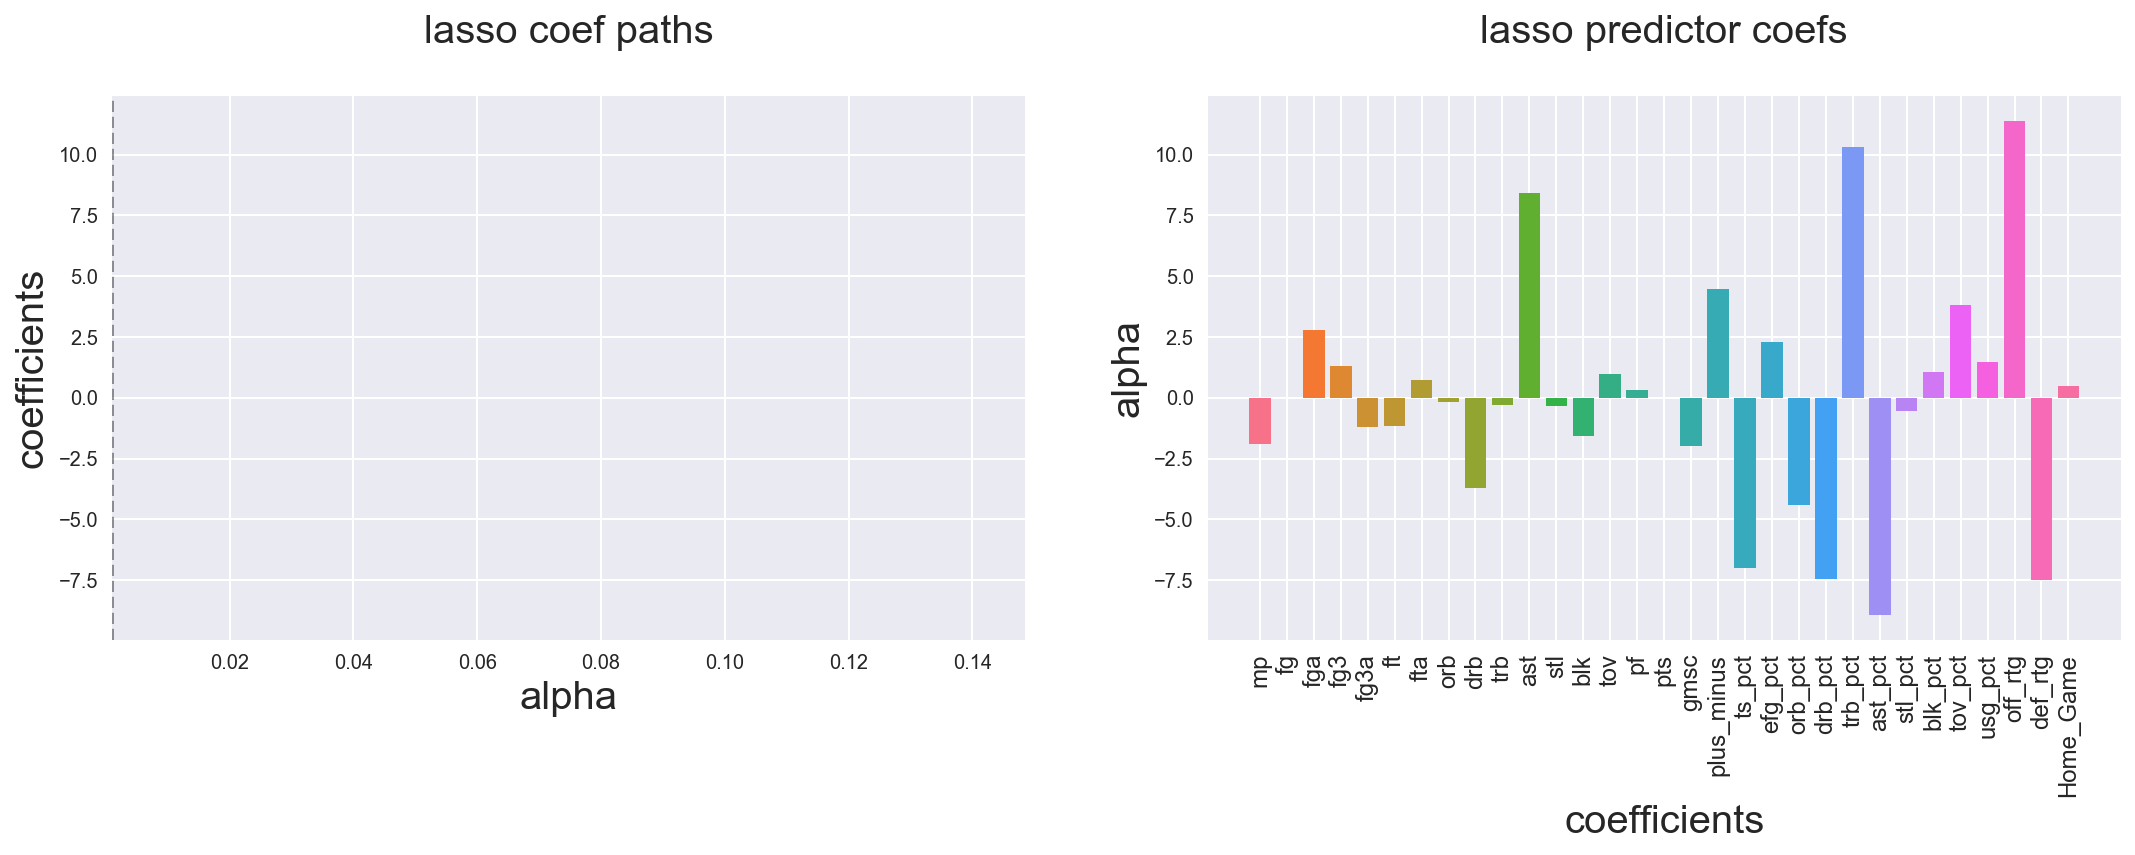

<function __main__.lasso_plot_runner>

In [78]:
def lasso_plot_runner(alpha=0):
    coef_plotter(l_alphas, l_coefs, X.columns, alpha, regtype='lasso')

interact(lasso_plot_runner, alpha=(0.001,0.2,0.0025))

- Contrast what is happening here with Ridge penalty.
- What do you notice about large vs small coefficients?
- At what point on the alpha axis does the affect begin to take place? Contrast with Ridge.

<a id='viz-elastic-net'></a>

## Visualizing the Elastic Net

---

Recall that the Elastic Net combines the Ridge and Lasso penalties.

`ElasticNet` in sklearn has two parameters:
- `alpha`: the regularization strength.
- `l1_ratio`: the amount of L1 vs L2 penalty. An l1_ratio of 0 is equivalent to the Ridge, whereas an l1_ratio of 1 is equivalent to the Lasso.


In [79]:
from sklearn.linear_model import ElasticNet

Calculate the coefficients with both alpha values and an l1_ratio of 0.05. Lasso can "overpower" the Ridge penalty in some datasets, and so rather than an equal balance I'm just adding a little bit of Lasso in.

In [80]:
# This is the same as the ridge coefficient by alpha calculator
def elasticnet_coefs(X, Y, alphas):
    coefs = []
    enet_reg = ElasticNet()
    for a in alphas:
        enet_reg.set_params(alpha=a, l1_ratio=0.05)
        enet_reg.fit(X, Y)
        coefs.append(enet_reg.coef_)
        
    return coefs

In [81]:
enet_alphas = np.arange(0.01, 1.0, 0.005)
enet_coefs = elasticnet_coefs(X, Y, enet_alphas)

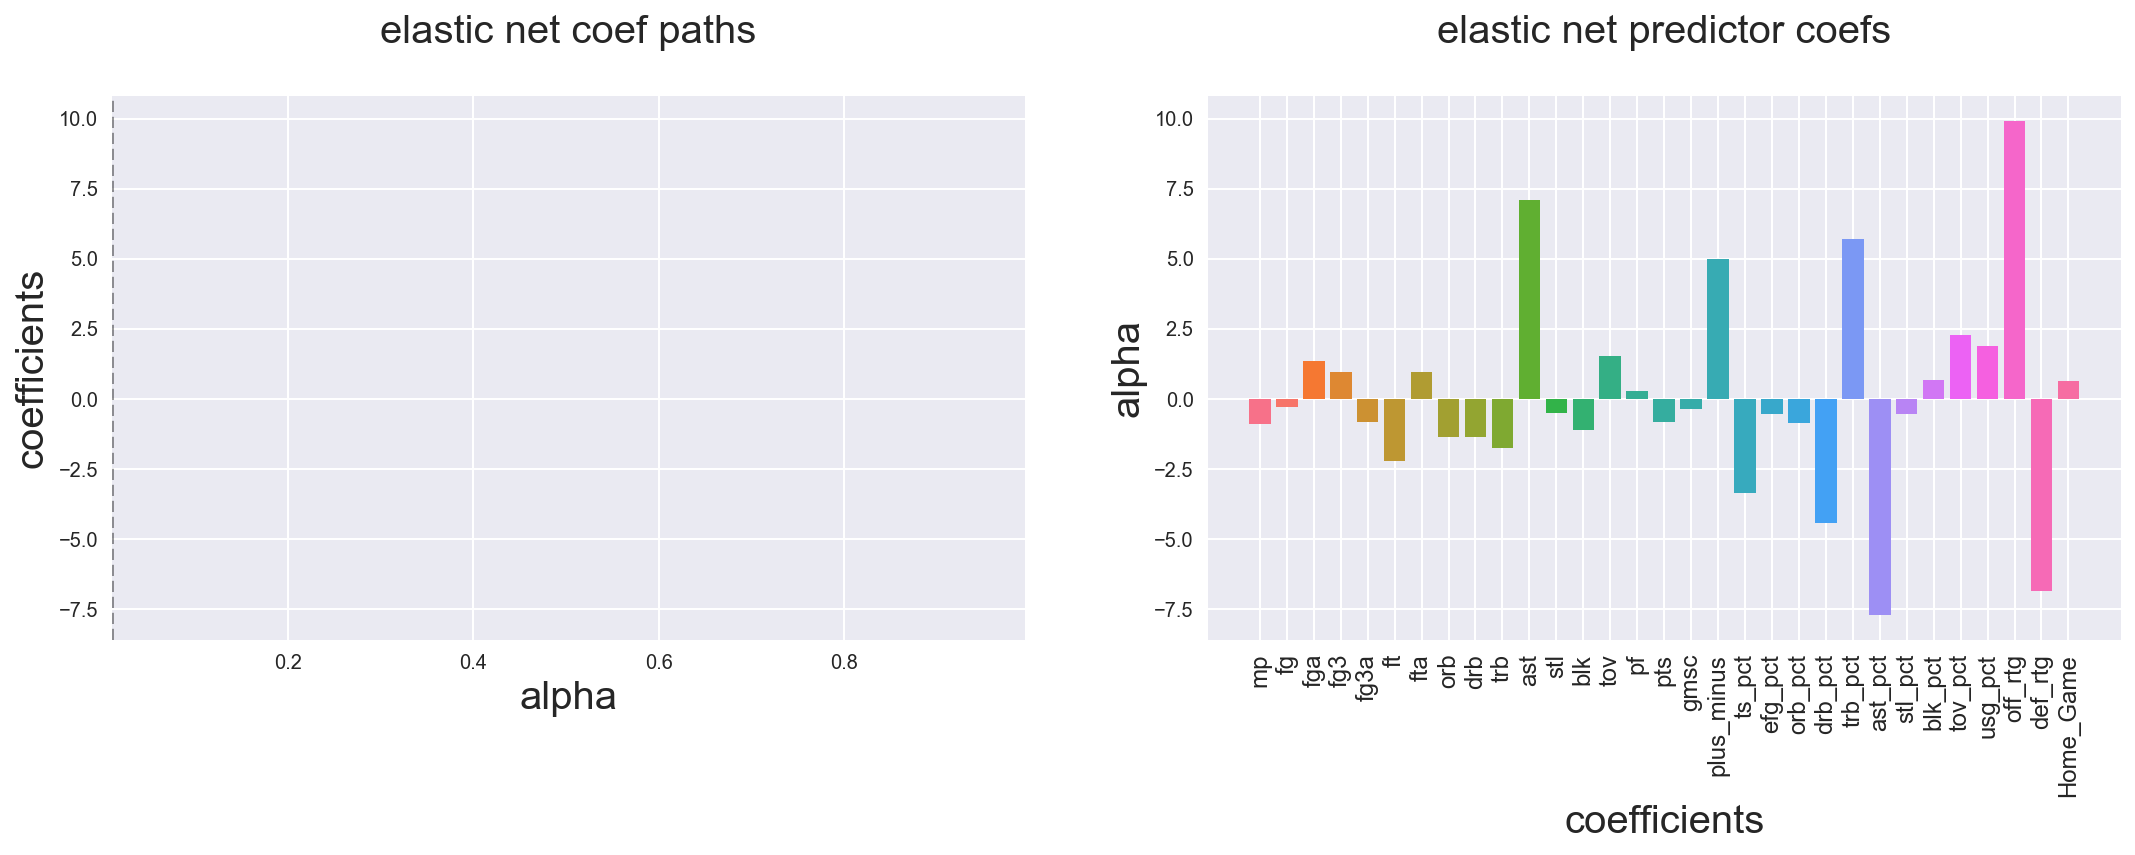

<function __main__.enet_plot_runner>

In [82]:
def enet_plot_runner(alpha=0.01):
    coef_plotter(enet_alphas, enet_coefs, X.columns, alpha, regtype='elastic net')

interact(enet_plot_runner, alpha=(0.0,1.0,0.005))

<a id='model-performance'></a>

## Model performance of the Ridge, Lasso and Elastic Net on the overfit data

---

Let's check out how the penalties affect the performance of our models. On the basic wine dataset there won't be much benefit to using regularization. We can switch over to the overfit data instead to see if regularization helps us control overfitting.

Load in the KFold crossvalidation function from sklearn. We'll make ten folds.

In [83]:
from sklearn.cross_validation import KFold
kfolds = KFold(wine.shape[0], n_folds=10)

For the Ridge, Lasso, and Elastic Net, iterate through their alphas and using the cross-validation folds calculate the average $R^2$ at each regularization level:

> Note: this may take awhile to run!

In [84]:
def ridge_lasso_cv_rsq(X, Y, r_alphas, l_alphas, e_alphas, kfolds, verbose=False):
    
    # lists to track mean R2s per alpha
    ridge_rsq = []
    lasso_rsq = []
    enet_rsq = []

    # initialize models
    lasso = Lasso()
    ridge = Ridge()
    enet = ElasticNet()

    print ('Lasso...')
    # iterate through Lasso alphas
    for la in l_alphas:
        
        if verbose: print (la)
        
        # set the current alpha to the model
        lasso.set_params(alpha=la)
        
        # keep track of fold R2s
        rsqs = []
        
        # iterate through the folds. Each iteration returns the training and
        # testing indices
        for traini, testi in kfolds:
            
            # run the current model with the subset training X and Y
            lasso.fit(X.iloc[traini, :], Y[traini])
            
            # append the R2 on the test set to the tracker
            rsqs.append(lasso.score(X.iloc[testi, :], Y[testi]))
            
        # append the mean of the R2s for this alpha to the R2 by alpha list
        lasso_rsq.append(np.mean(rsqs))

    print ('Ridge...')
    # Do the same process as above for ridge...
    for ra in r_alphas:
        
        if verbose: print (ra)
        
        ridge.set_params(alpha=ra)
        rsqs = []
        for traini, testi in kfolds:
            ridge.fit(X.iloc[traini, :], Y[traini])
            rsqs.append(ridge.score(X.iloc[testi, :], Y[testi]))
        ridge_rsq.append(np.mean(rsqs))
        
    print ('ElasticNet...')
    # Do the same process as above for ridge...
    for ea in e_alphas:
        
        if verbose: print (ea)
        
        enet.set_params(alpha=ea, l1_ratio=0.5)
        rsqs = []
        for traini, testi in kfolds:
            enet.fit(X.iloc[traini, :], Y[traini])
            rsqs.append(enet.score(X.iloc[testi, :], Y[testi]))
        enet_rsq.append(np.mean(rsqs))
        
    from sklearn.linear_model import LinearRegression
    
    linreg_rsq = []
    linreg = LinearRegression()
    for traini, testi in kfolds:
        linreg.fit(X.iloc[traini, :], Y[traini])
        linreg_rsq.append(linreg.score(X.iloc[testi, :], Y[[testi]]))
        
    linreg_rsq = np.mean(linreg_rsq)
        
    return ridge_rsq, lasso_rsq, enet_rsq, linreg_rsq
    
# Get the ridge and lasso cross-validated R2s:
ridge_rsq, lasso_rsq, enet_rsq, linreg_rsq = ridge_lasso_cv_rsq(X, Y, r_alphas, 
                                                                l_alphas, enet_alphas, kfolds)


Lasso...


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Below we have a new plotting function that will track the performance of the model as the alphas increase, as measured by the mean $R^2$s across cross-validation folds. Remember that $R^2$ is a measure of how much variance in the target/dependent variable is explained by our predictor variables.

In [106]:
def rsq_plotter(ridge_alphas, ridge_to_alpha, ridge_rsq,
                lasso_alphas, lasso_to_alpha, lasso_rsq,
                enet_alphas, enet_to_alpha, enet_rsq,
                linreg_rsq):
    
    
    # Find the overall minimum and maximum alpha values for
    # the Ridge and Lasso to fix the plot axes:
    ridge_amin = np.min(ridge_alphas)
    ridge_amax = np.max(ridge_alphas)
    
    lasso_amin = np.min(lasso_alphas)
    lasso_amax = np.max(lasso_alphas)
    
    enet_amin = np.min(enet_alphas)
    enet_amax = np.max(enet_alphas)
    
    # Subet the models' alphas and rsqs according to the currently set
    # alpha limits for each (passed in from the interactive sliders)
    ridge_alphas = [a for a in ridge_alphas if a <= ridge_to_alpha]
    ridge_rsq = ridge_rsq[0:len(ridge_alphas)]
    
    lasso_alphas = [a for a in lasso_alphas if a <= lasso_to_alpha]
    lasso_rsq = lasso_rsq[0:len(lasso_alphas)]
    
    enet_alphas = [a for a in enet_alphas if a <= enet_to_alpha]
    enet_rsq = enet_rsq[0:len(enet_alphas)]
    
    # Get some unique colors out for the Ridge R2 line, Lasso R2 line,
    # Enet R2, and the 'max R2 achieved' line.
    colors = sns.xkcd_palette(['windows blue', 'amber', 'dark red', 'faded green'])

    # We will again be plotting two axes on the same figure:
    fig = plt.figure()
    fig.set_size_inches(18,7)

    # The first subplot axes is for the ridge
    ax1 = fig.add_subplot(131)
    
    # Plot a vertical line indicating the current alpha selected
    ax1.axvline(ridge_to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot a horizontal line for the vanilla linear regression R^2
    ax1.axhline(linreg_rsq, lw=2, c=colors[2], alpha=0.8)
    
    # Plot the line tracking R2s by alpha values
    ax1.plot(ridge_alphas, ridge_rsq, lw=3, c=colors[0])
    
    # Add the axis labels
    ax1.set_xlabel('ridge alpha', fontsize=20)
    ax1.set_ylabel('ridge CV R2', fontsize=20)
    
    # Set x-axis to logarithmic scale
    ax1.set_xscale('log')
    
    # Fix the axes in place
    ax1.set_xlim([ridge_amin, ridge_amax])
    ax1.set_ylim([-0.05, 1])
    
    # set the title for the axes;
    ax1.set_title('ridge cross-val performance\n', fontsize=20)
    
    
    # Now do all of this as above for the Lasso!
    ax2 = fig.add_subplot(132)
    ax2.axvline(lasso_to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    ax2.axhline(linreg_rsq, lw=2, c=colors[2], alpha=0.8)
    
    ax2.plot(lasso_alphas, lasso_rsq, lw=3, c=colors[0])
    
    ax2.set_xlabel('lasso alpha', fontsize=20)
    ax2.set_ylabel('lasso CV R2', fontsize=20)
    ax2.set_xlim([lasso_amin, lasso_amax])
    ax2.set_ylim([-0.05, 1])
        
    ax2.set_title('lasso cross-val performance\n', fontsize=20)
    
    
    # And ElasticNet:
    ax3 = fig.add_subplot(133)
    ax3.axvline(enet_to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    ax3.axhline(linreg_rsq, lw=2, c=colors[3], alpha=0.8)
    
    ax3.plot(enet_alphas, enet_rsq, lw=3, c=colors[0])
    
    ax3.set_xlabel('enet alpha', fontsize=20)
    ax3.set_ylabel('enet CV R2', fontsize=20)
    ax3.set_xlim([enet_amin, enet_amax])
    ax3.set_ylim([-0.05, 1])
        
    ax3.set_title('enet cross-val performance\n', fontsize=20)
    
    plt.show()

In [107]:
# We have our new widget where you can change both the Ridge and Lasso alphas to see how they compare:

def rsq_plot_pipe(ra, la, ea):
    rsq_plotter(r_alphas, 10**ra, ridge_rsq, l_alphas, la, lasso_rsq, enet_alphas, ea, enet_rsq, linreg_rsq)
    
w = widgets.interactive(rsq_plot_pipe, 
                        ra=widgets.FloatSlider(value=0, min=0., max=5., step=0.05, description='Ridge log10(alpha):'),
                        la=widgets.FloatSlider(value=0, min=0., max=0.2, step=0.0025, description='Lasso alpha:'),
                        ea=widgets.FloatSlider(value=0, min=0., max=1.0, step=0.005, description='Enet alpha:')
)

display(w)

NameError: global name 'ridge_rsq' is not defined

- Articulate what is regularization for regression models
- Define how regularization modifies the loss function
- Define the effect of regularization on coefficients
- Define the differences between the Lasso, Ridge, and ElasticNet

- How do the different regularization methods you have learned deal with the various overfitting cases we talked about at the beginning of class?